In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split


In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [3]:
data =pd.read_csv('tourist data.csv')

In [4]:
data

,ID,location,review,sentiment
0,1,Syambhunath,It is at the top of valleys mountain. Best pl...,1
1,2,Syambhunath,This place has a significant importance in Bud...,1
2,3,Syambhunath,Visited this from the other side on a rainy ev...,1
3,4,Syambhunath,A beautiful temple situated in the capital wit...,1
4,5,Syambhunath,"great, beautiful, historic & religious place.....",1
...,...,...,...,...
7097,7267,Pokhara,"It's a nice place to sit back, and enjoy. The ...",1
7098,7268,Pokhara,"Excellent Place to visit, Lifetime memories",1
7099,7269,Pokhara,It's very photogenic and relaxing when there a...,1
7100,7270,Pokhara,U can get real definition of nature's beauty a...,1


In [5]:
data.drop(data.loc[data['sentiment']==0].index, inplace=True)


In [6]:
data

,ID,location,review,sentiment
0,1,Syambhunath,It is at the top of valleys mountain. Best pl...,1
1,2,Syambhunath,This place has a significant importance in Bud...,1
2,3,Syambhunath,Visited this from the other side on a rainy ev...,1
3,4,Syambhunath,A beautiful temple situated in the capital wit...,1
4,5,Syambhunath,"great, beautiful, historic & religious place.....",1
...,...,...,...,...
7097,7267,Pokhara,"It's a nice place to sit back, and enjoy. The ...",1
7098,7268,Pokhara,"Excellent Place to visit, Lifetime memories",1
7099,7269,Pokhara,It's very photogenic and relaxing when there a...,1
7100,7270,Pokhara,U can get real definition of nature's beauty a...,1


In [7]:
data_clean = pd.DataFrame(data)

In [8]:
train, test = train_test_split(data_clean, test_size=0.2, random_state=1)
X_train = train['review'].values
X_test = test['review'].values
y_train = train['sentiment']
y_test = test['sentiment']

In [9]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)


In [10]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [11]:
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


0.9231268011527378

In [12]:
grid_svm.best_params_


{'svc__C': 0.01}

In [13]:
grid_svm.best_score_


0.8818046739674841

In [14]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [15]:
report_results(grid_svm.best_estimator_, X_test, y_test)


{'auc': 0.9231268011527378,
 'f1': 0.952286282306163,
 'acc': 0.9111933395004626,
 'precision': 0.9866117404737385,
 'recall': 0.920268972142171}

In [16]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

In [17]:
roc_svm = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)

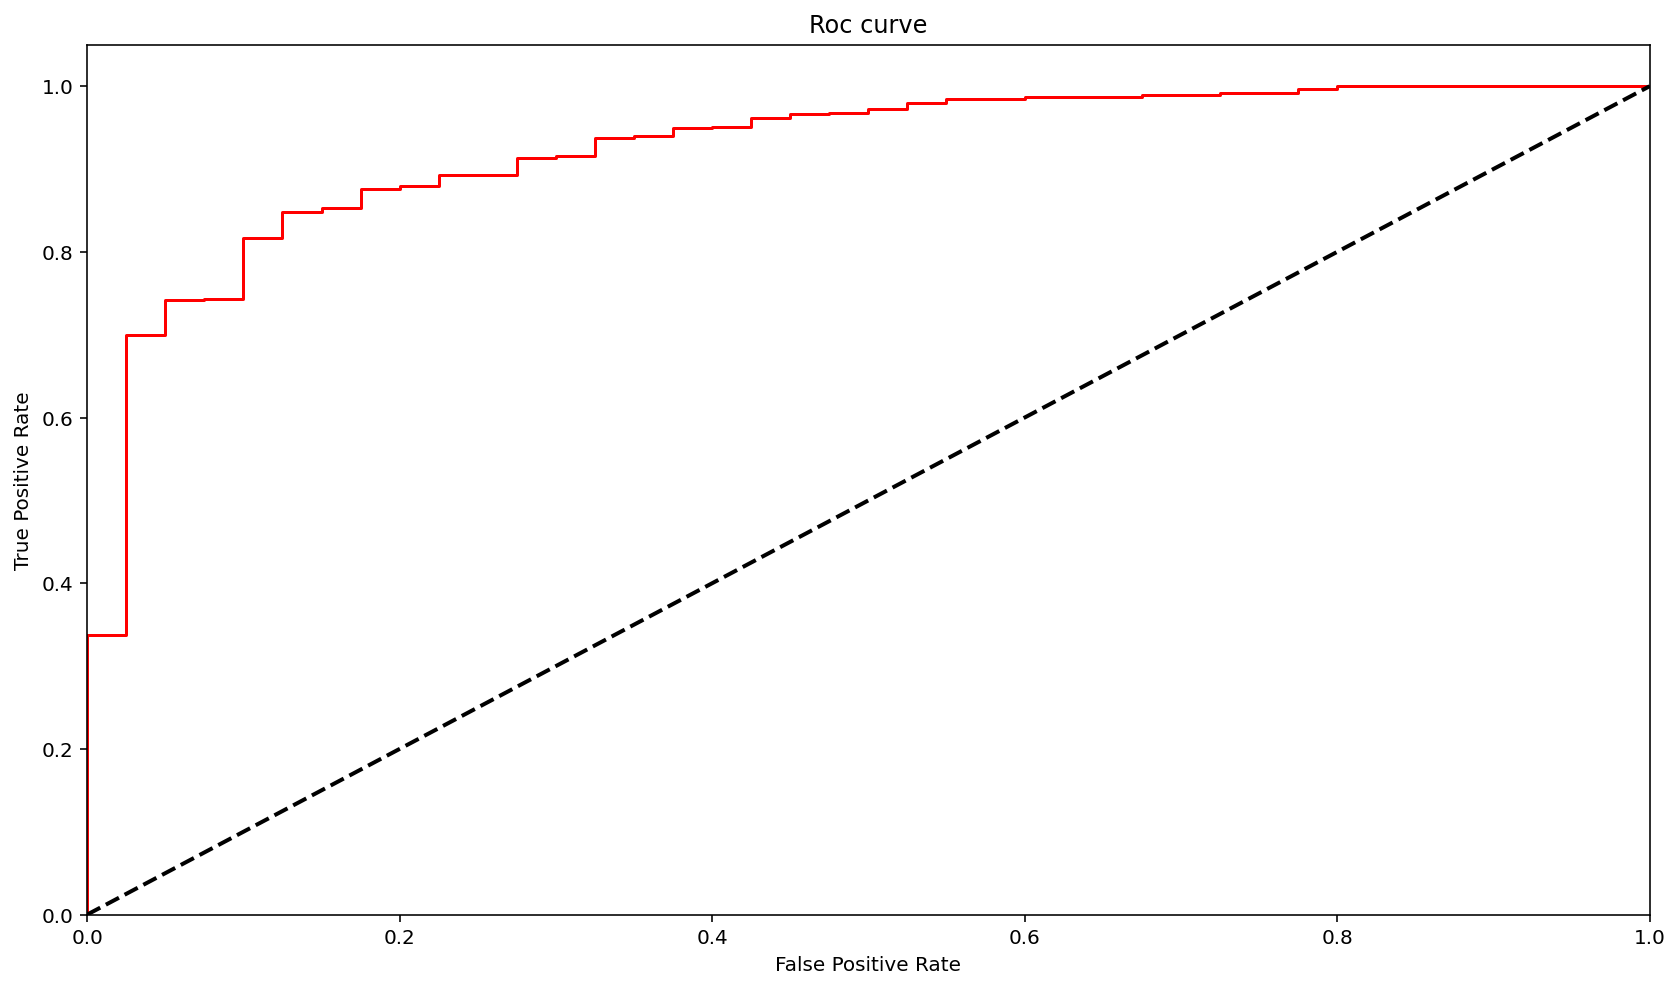

In [18]:
fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

In [19]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(grid_svm.best_estimator_, X_train, y_train, cv=5, n_jobs=-1, 
                   scoring="roc_auc", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

In [20]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
                     
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
             
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")


    plt.legend(loc="lower right")
    return plt

  

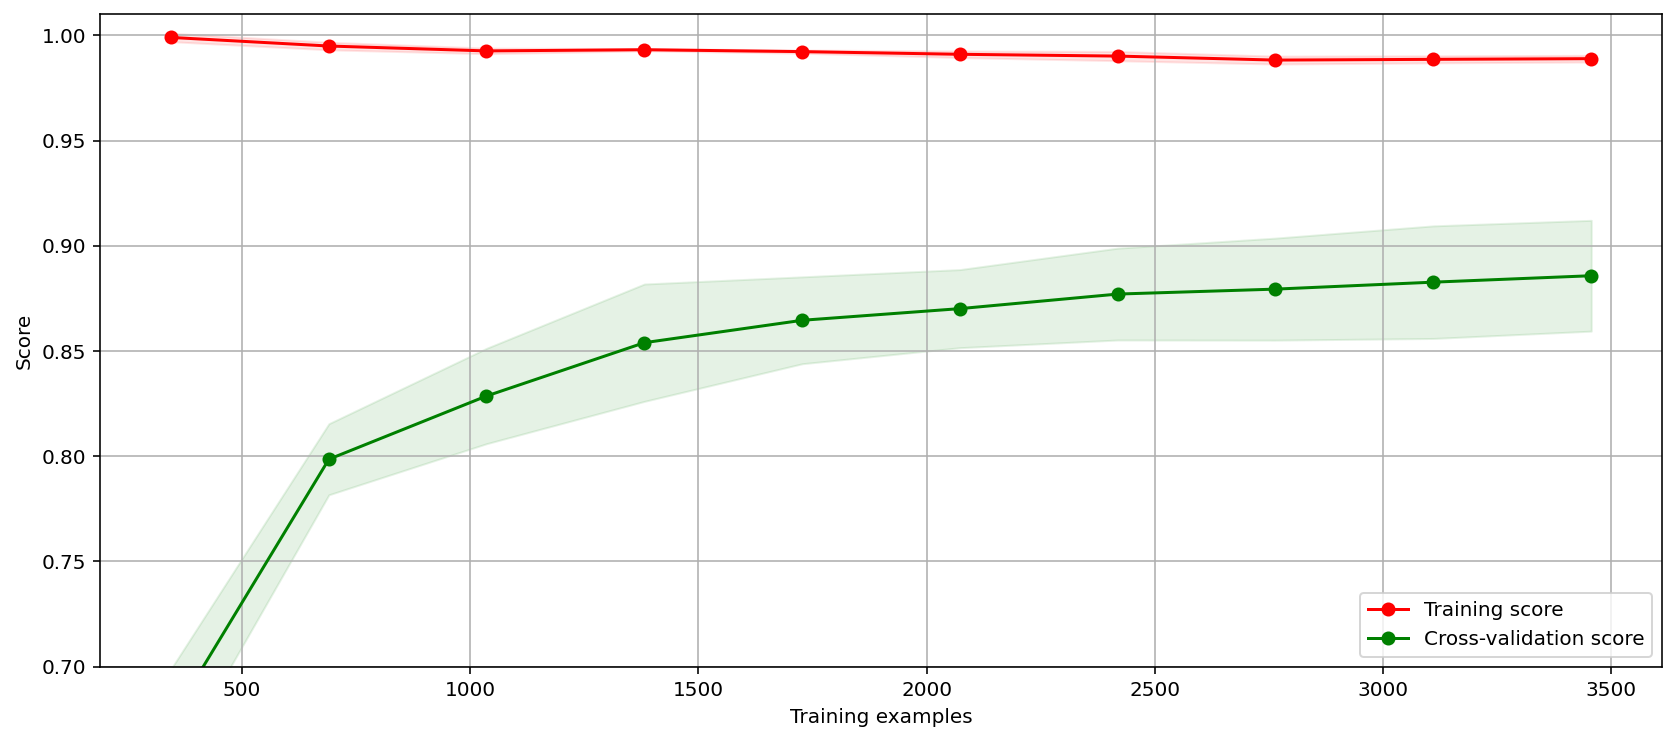

In [21]:
plot_learning_curve(X_train, y_train, train_sizes, 
                    train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()